## 0. Basic Packages

In [1]:
import pandas as pd
#Set copy warning to off
pd.set_option('mode.chained_assignment', None)
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

##### We import all the functions used in the previous notebooks

In [2]:
from nlp_preprocess import *

##### We add accents to stop_words and exclude the words we want

In [3]:
from nltk.corpus import stopwords

#we select the spanish stop words (by default all the words with accents have them)
stop_words = stopwords.words('spanish')

#now we have the words with accents and the same ones without accents
stop_words = add_non_accents(stop_words)

#list to exclude in stop_words (excluded based in "count_stop_words" fn)
stop_w_list = ["no", "mucho", "muchos", "tiene", "tienen", "otras", "sin", "nada", "algo"
               "tanto", "alguna", "estamos", "tengan", "tenemos", "nuestros", "fuera", "algunos", "hasta"]

#exclude previous list of words from stop_words
stop_words.difference_update(stop_w_list)

## 1. Data Wrangling

In [4]:
f1 = pd.read_excel("comments.xlsx", [0])[0]
f2 = pd.read_excel("comments.xlsx", [1])[1]

df = pd.concat([f1, f2]) 
df.rename(columns={"Initial Classification":"Initial_Classification"}, inplace=True)
print(df.shape)
df.head()

(584, 4)


,ID,Area,Comment,Initial_Classification
0,1,Dept 1,Cerrar la brecha entre los que deciden el trab...,Negativo
1,3,Dept 1,"Sobretodo, que se miren las cargas de trabajo ...",Negativo
2,4,Dept 1,1. Dar coaching a algunos Gerentes (que no sab...,Negativo
3,19,Dept 1,s,Negativo
4,29,Dept 1,Mas oportunidades de crecimiento y major salar...,Negativo


### Checking for nulls

In [5]:
#cecking for nulls
df.isna().sum()

ID                         0
Area                       0
Comment                   11
Initial_Classification     0
dtype: int64

In [6]:
#checking data type
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 584 entries, 0 to 291
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   ID                      584 non-null    int64 
 1   Area                    584 non-null    object
 2   Comment                 573 non-null    object
 3   Initial_Classification  584 non-null    object
dtypes: int64(1), object(3)
memory usage: 22.8+ KB


In [7]:
#cheking the null comments
df[df.Comment.isna()]

,ID,Area,Comment,Initial_Classification
12,120,Dept 1,NaN,Negativo
48,561,Dept 4,NaN,Negativo
109,1280,Dept 7,NaN,Negativo
129,1475,Dept 9,NaN,Negativo
158,1768,Dept 9,NaN,Negativo
227,2481,Dept 9,NaN,Negativo
240,2587,Dept 9,NaN,Negativo
274,2850,Dept 10,NaN,Negativo
277,2887,Dept 10,NaN,Negativo
227,2481,Dept 9,NaN,Positivo


### Updating nulls with NA

In [8]:
#we will replace with the term "NA"
df.Comment[df.Comment.isna()] = "NA"

### Lowering comments

In [9]:
df.Comment = df.Comment.str.lower()

## 2. Preprocess

### Detecting language

In [10]:
#we create a new column with the detected lang
#choose between langdetect or cld3. By default cld3, which works bettter (for es)
df["language"] = dect_lang(df.Comment, detector="langdetect")

In [11]:
#we check the non-snpanish ones
for c, l in zip(df.Comment[df.language!="es"], df.language[df.language!="es"]):
    print("Sentence:", c, "---->", "Lang:", l)

Sentence: s ----> Lang: sv
Sentence: prefiero no comentar ----> Lang: it
Sentence: na ----> Lang: tl
Sentence: more alignment in priorities to focus more and accomplish better results. we try to do too much at the same time, limiting the chances of success.  ----> Lang: en
Sentence: reduce legal and compliance bureaucracy. there is a pervasive view that lawyers and risk managers can manage the business from afar. client facing employees are handcuffed and more worrisome, at times prefer not to look for better alternatives for clients afraid that they might run afoul of one of the many new rules. also, innovation is stifled by all the roadblocks and permissions needed to launch a product or service.  ----> Lang: en
Sentence: no cambiaria nada. ----> Lang: pt
Sentence: ninguna. ----> Lang: tl
Sentence: los salarios justos  ----> Lang: lt
Sentence: nada ----> Lang: so
Sentence: mejorar la paga ----> Lang: id
Sentence: na ----> Lang: tl
Sentence: no cambiaria nada. ----> Lang: pt
Sentence:

Once we have checked the previous output we can see the english comments are well identified, and the rest are either, errors / sentences with no meaning, or spanish sentences identified as catalan, italian or other language

Therefore it is fair to consider, non-english comments as spanish comments in this case

In [12]:
#we replace non-english comments for "es" term
df.language[df.language!="en"] = "es"

In [13]:
#we re-check the list again
for c, l in zip(df.Comment[df.language!="es"], df.language[df.language!="es"]):
    print("Sentence:", c, "---->", "Lang:", l)

Sentence: more alignment in priorities to focus more and accomplish better results. we try to do too much at the same time, limiting the chances of success.  ----> Lang: en
Sentence: reduce legal and compliance bureaucracy. there is a pervasive view that lawyers and risk managers can manage the business from afar. client facing employees are handcuffed and more worrisome, at times prefer not to look for better alternatives for clients afraid that they might run afoul of one of the many new rules. also, innovation is stifled by all the roadblocks and permissions needed to launch a product or service.  ----> Lang: en
Sentence: nothing specific ----> Lang: en
Sentence: some businesses within la empresa should be evaluated/treated differently than the rest of the company... because they are vey different in nature. employees / businesses should not be punished for situations that occurred more than 10 years ago under very different industry/market conditions.  ----> Lang: en
Sentence: most

### Creating Dataframe for each Language

In [14]:
df_es = df[df.language=="es"]
df_en = df[df.language=="en"]

### Positive vs Negative Comments, Preprocess & Clean

In [15]:
#separate comments by type
neg_comments_es = df_es.Comment.values[df_es.Initial_Classification=="Negativo"]
pos_comments_es = df_es.Comment.values[df_es.Initial_Classification=="Positivo"]

#clean comments
n_clean_comments_es = clean_comments(neg_comments_es)
p_clean_comments_es = clean_comments(pos_comments_es)


#1. set root to "no" if you don't want the root (lemma) of the word, but the original world (default="yes")
#2. set stop_w to "yes" if you want to include stop_words (default="no")
n_pre_comments_es = preprocess(n_clean_comments_es, root="no", stop_w="no", stop_words=stop_words)
p_pre_comments_es = preprocess(p_clean_comments_es, root="no", stop_w="no", stop_words=stop_words)

#flatten comments in a list
n_flatten_comments_es = [" ".join(comments) for comments in n_pre_comments_es]
p_flatten_comments_es = [" ".join(comments) for comments in p_pre_comments_es]

## 3. Topic Modeling

In [16]:
tokens = input("Select between the group of comments\n'n_flatten_comments_es' (negative)\n'p_flatten_comments_es' (positive)\n")

while tokens != "n_flatten_comments_es" and tokens != "n_flatten_comments_es":
    tokens = input("Select between the one of them")
    
if tokens == "n_flatten_comments_es":
    tokens = [c.split() for c in n_flatten_comments_es]
elif tokens == "p_flatten_comments_es":
    tokens = [c.split() for c in p_flatten_comments_es]

Select between the group of comments
'n_flatten_comments_es' (negative)
'p_flatten_comments_es' (positive)
n_flatten_comments_es


In [17]:
from gensim.corpora.dictionary import Dictionary
from gensim.models import CoherenceModel, LdaModel

dictionary = Dictionary(tokens)
corpus = [dictionary.doc2bow(text) for text in tokens]

0 LdaModel(num_terms=1590, num_topics=1, decay=0.5, chunksize=2000) 0.306471737068365
1 LdaModel(num_terms=1590, num_topics=2, decay=0.5, chunksize=2000) 0.278023270421941
2 LdaModel(num_terms=1590, num_topics=3, decay=0.5, chunksize=2000) 0.3075857702915794
3 LdaModel(num_terms=1590, num_topics=4, decay=0.5, chunksize=2000) 0.32788281720713286
4 LdaModel(num_terms=1590, num_topics=5, decay=0.5, chunksize=2000) 0.2931489310077806
5 LdaModel(num_terms=1590, num_topics=6, decay=0.5, chunksize=2000) 0.27672845404262275
6 LdaModel(num_terms=1590, num_topics=7, decay=0.5, chunksize=2000) 0.3157281185517415
7 LdaModel(num_terms=1590, num_topics=8, decay=0.5, chunksize=2000) 0.34847348659676325
8 LdaModel(num_terms=1590, num_topics=9, decay=0.5, chunksize=2000) 0.33285797892750746
9 LdaModel(num_terms=1590, num_topics=10, decay=0.5, chunksize=2000) 0.3268686334684462
10 LdaModel(num_terms=1590, num_topics=11, decay=0.5, chunksize=2000) 0.3318782254056301
11 LdaModel(num_terms=1590, num_topics

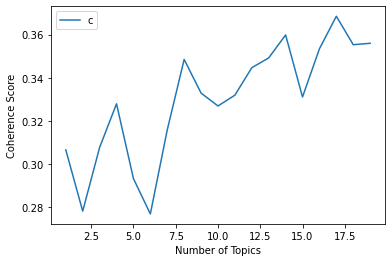

In [18]:
limit = 20
model_coherence = []
range_limit = range(1, limit)
for n in range_limit:
    lm = LdaModel(corpus=corpus, num_topics=n, id2word=dictionary)
    cm = CoherenceModel(model=lm, texts=tokens, dictionary=dictionary, coherence='c_v')
    print(n-1, lm, cm.get_coherence())
    model_coherence.append((lm, cm.get_coherence()))

# Show graph
plt.plot(range_limit, [x[1] for x in model_coherence])
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.legend(("c_v"), loc='best')
plt.show()

In [19]:
topic_model = sorted(model_coherence, key=lambda x: x[1], reverse=True)[0][0]

In [20]:
import re

for i, t in topic_model.print_topics():
    print (i, " ".join(re.findall( r'\*(.[^\*-S]+).?', t)), "\n")

0 "trabajo"  "empleados"  "compensacion"  "sistema"  "cambiaria"  "tengan"  "ser"  "mayor"  "unidades"  "mejor" 

1 "trabajo"  "mejorar"  "tener"  "empresa"  "trabajar"  "empleados"  "momento"  "tareas"  "dia"  "algunos" 

2 "empresa"  "empleados"  "mismo"  "ser"  "areas"  "trabajo"  "dias"  "ahora"  "deberian"  "mejores" 

3 "empleados"  "servicio"  "mejor"  "forma"  "comunicacion"  "empresa"  "facilidades"  "economico"  "talento"  "veces" 

4 "trabajo"  "empleados"  "manera"  "laboral"  "gerencia"  "area"  "procesos"  "departamento"  "personas"  "mejor" 

5 "empleados"  "posicion"  "siempre"  "trabajar"  "ejemplo"  "mucho"  "compensacion"  "ser"  "empresa"  "trabajo" 

6 "empleados"  "empresa"  "muchas"  "paga"  "entiendo"  "muchos"  "trabajo"  "menos"  "dia"  "cambiaria" 

7 "areas"  "cliente"  "empleado"  "servicio"  "trabajo"  "tareas"  "veces"  "responsabilidad"  "funciones"  "dificil" 

8 "empleados"  "asi"  "procesos"  "empleado"  "muchas"  "nivel"  "igualdad"  "mismos"  "reali

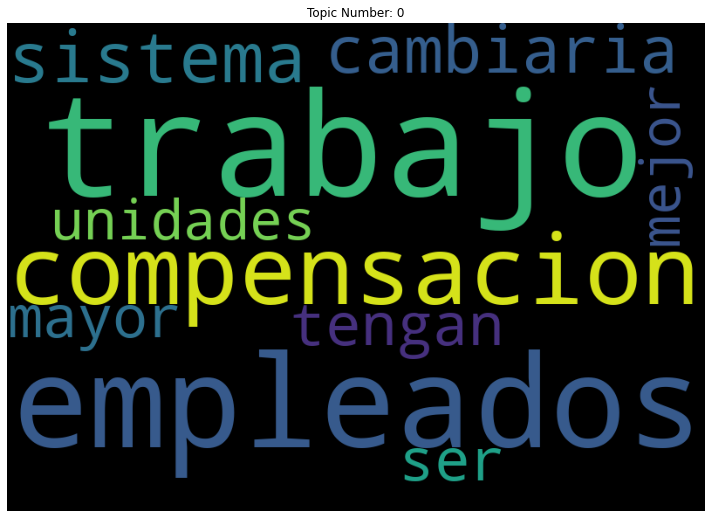

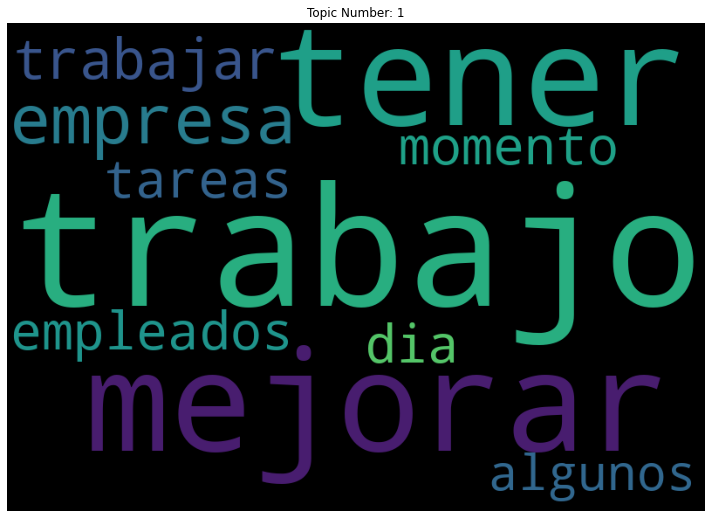

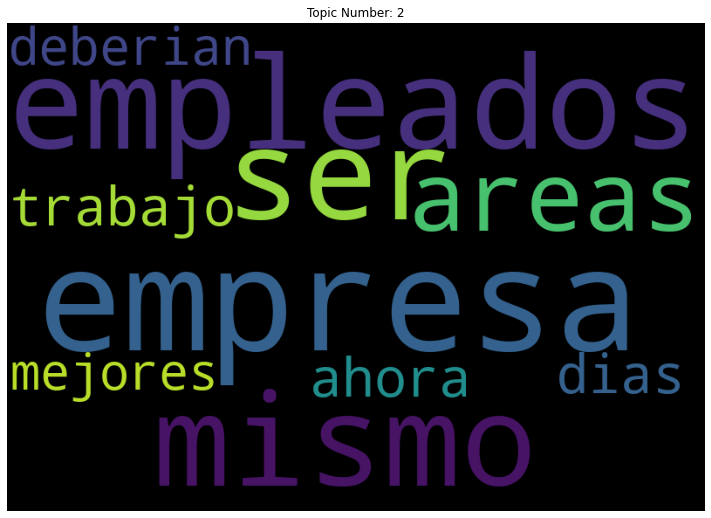

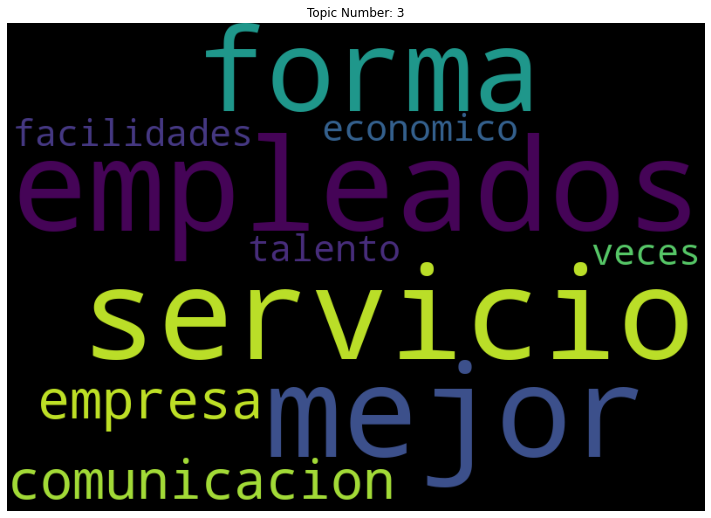

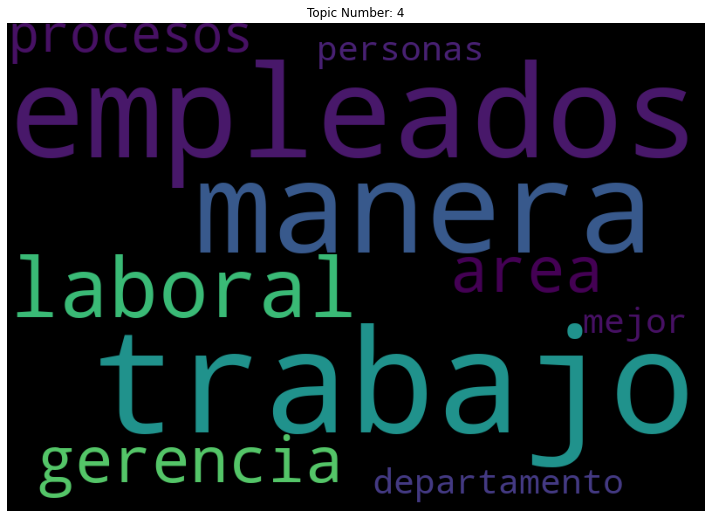

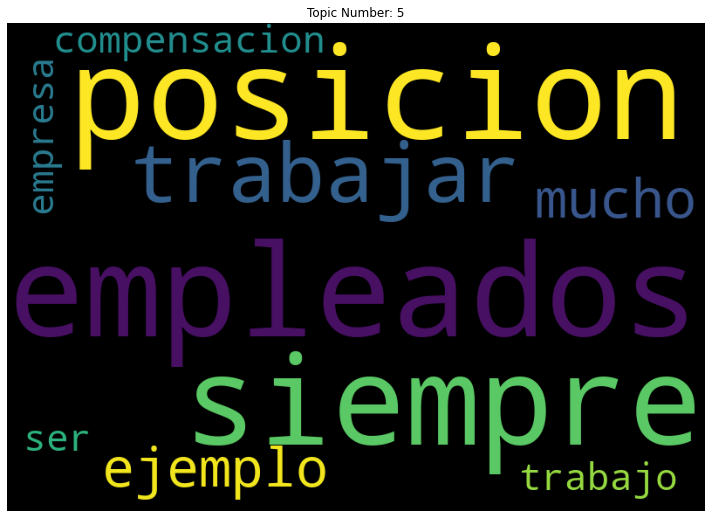

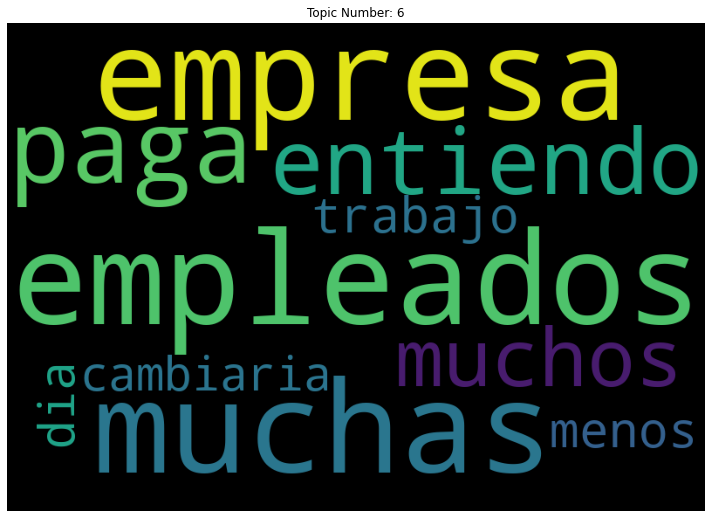

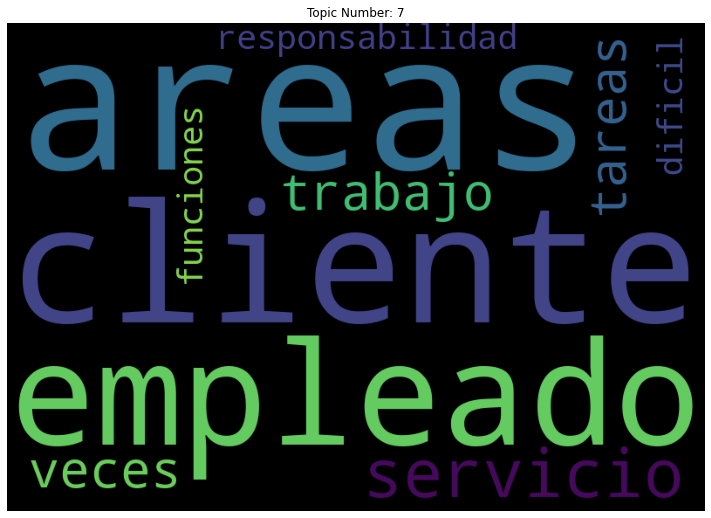

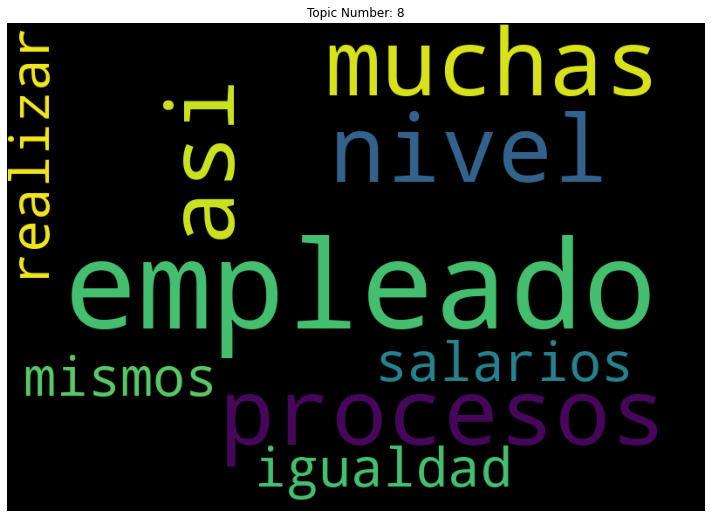

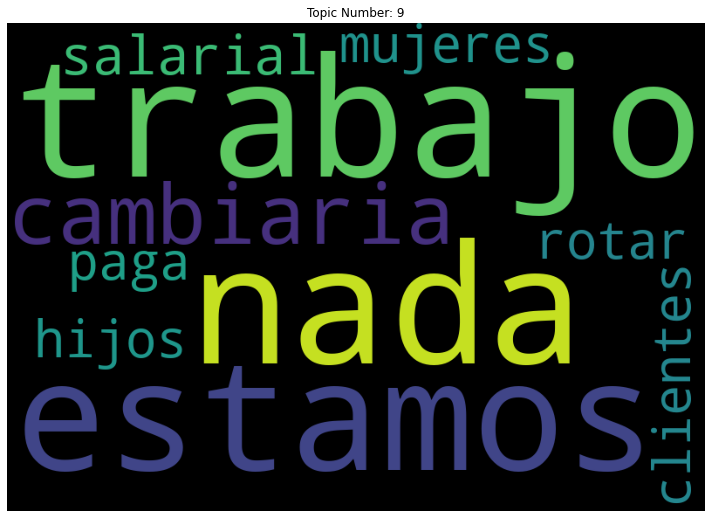

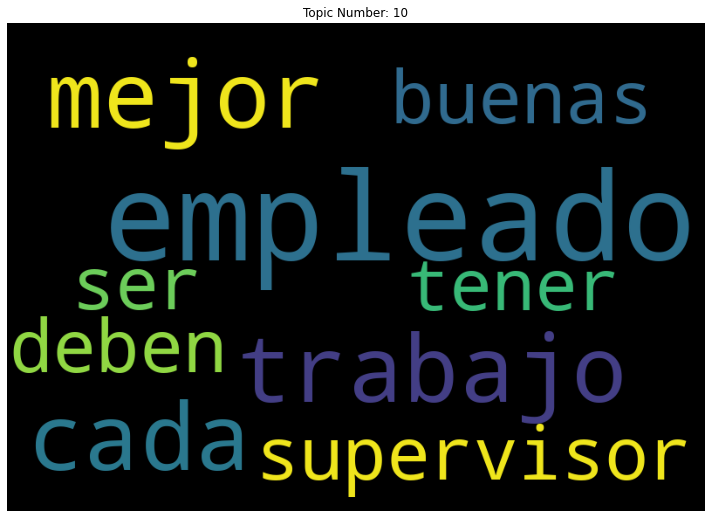

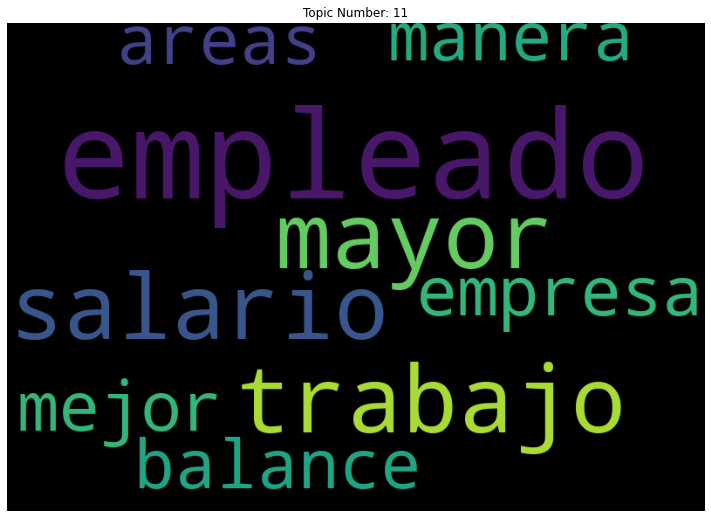

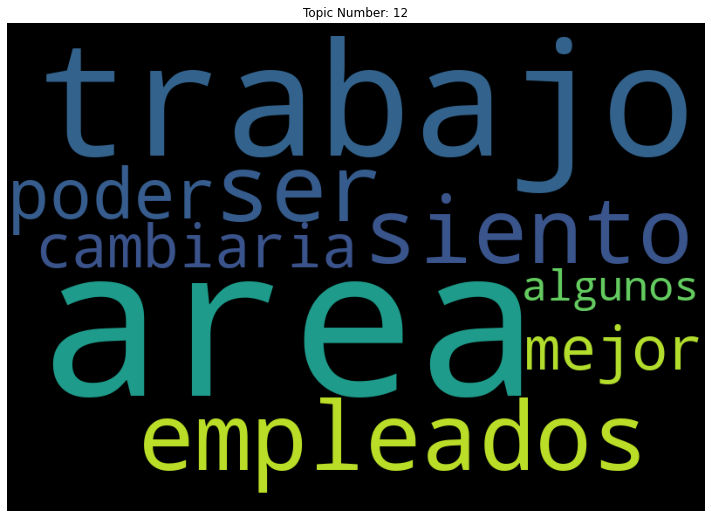

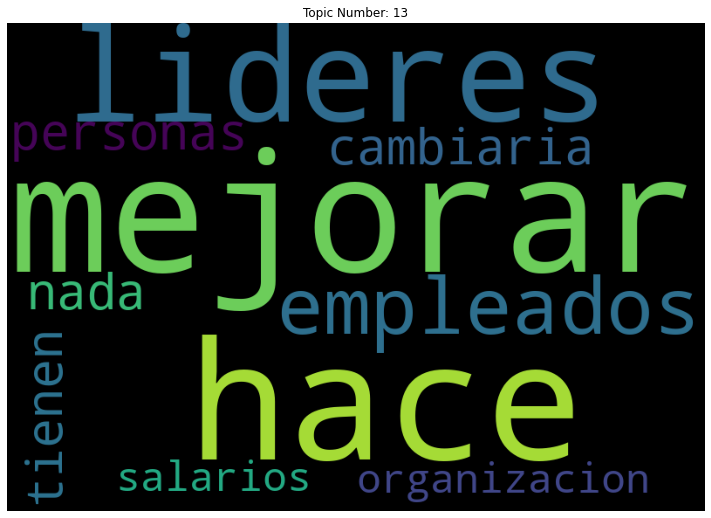

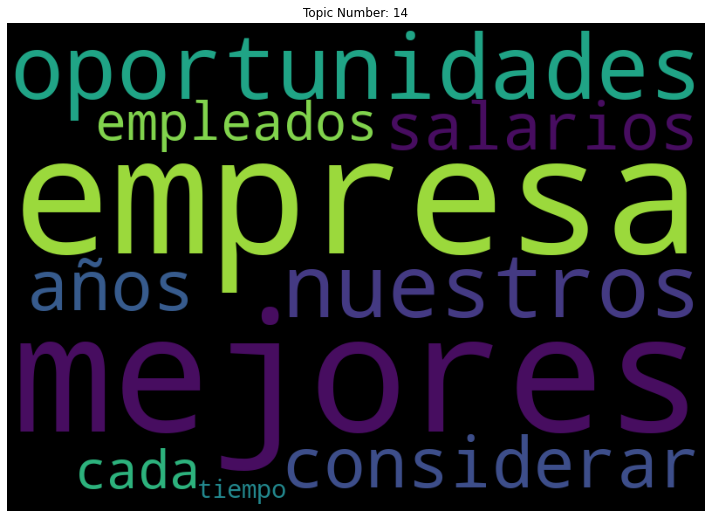

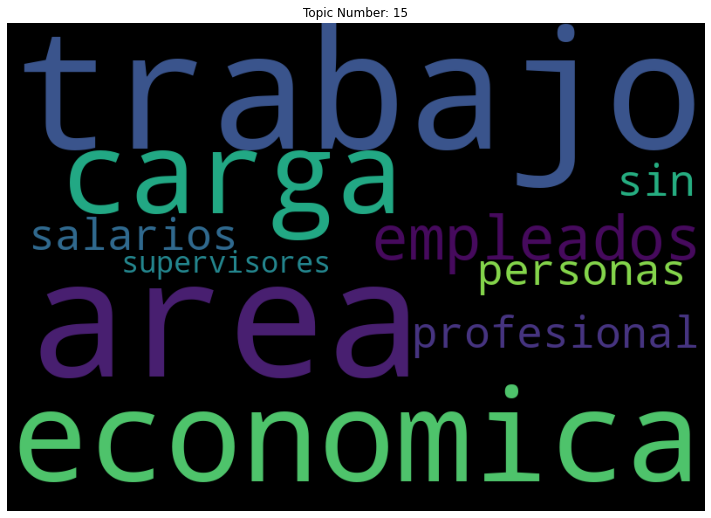

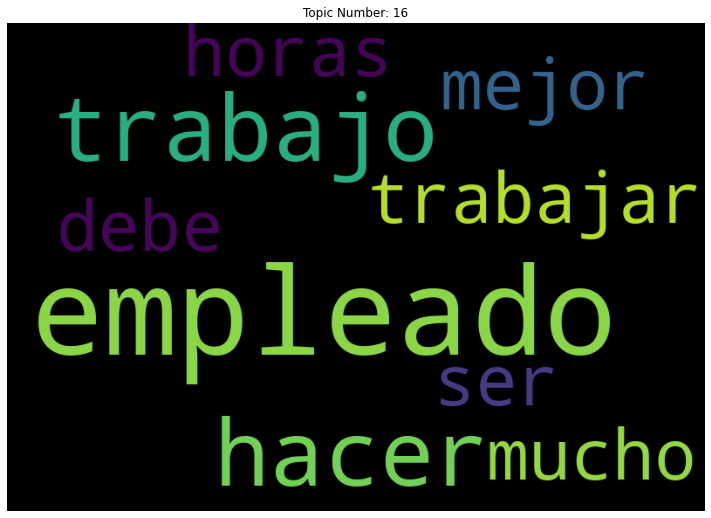

In [21]:
from wordcloud import WordCloud

for i, t in topic_model.print_topics():
    
    wordcloud = WordCloud(width=800, height=560,
                      background_color='black', collocations=False,
                      min_font_size=10).generate(t)

    # plot the WordCloud image
    plt.figure(figsize=(15, 7), facecolor=None)
    plt.title(f"Topic Number: {i}")
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)

In [22]:
import pyLDAvis
import pyLDAvis.gensim

pyLDAvis.enable_notebook()

pyLDAvis.gensim.prepare(topic_model, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
16     0.017485  0.104301       1        1  18.682590
5     -0.086025  0.054056       2        1  13.340111
11     0.041751  0.096973       3        1   8.619055
15     0.120712  0.033118       4        1   7.067787
14    -0.115847 -0.061222       5        1   6.041988
12     0.103542 -0.006742       6        1   5.960114
6      0.017783 -0.048565       7        1   5.113092
13     0.059894 -0.125055       8        1   4.885133
8     -0.054103  0.002181       9        1   4.564290
4     -0.019692  0.013218      10        1   4.051438
0      0.004602  0.028211      11        1   3.905046
1     -0.058898  0.019011      12        1   3.888949
3     -0.000002 -0.036724      13        1   3.843986
2     -0.048700 -0.002966      14        1   3.340068
10     0.015277 -0.003976      15        1   2.707148
9      0.023308 -0.075780      16        1   2.654559
7     -0.021087  0.009959      17        1   1.334646, topic_info=          Term       Freq      Total Category  logprob  loglift
10     trabajo  76.000000  76.000000  Default  30.0000  30.0000
79   empleados  58.000000  58.000000  Default  29.0000  29.0000
190    empresa  29.000000  29.000000  Default  28.0000  28.0000
133    mejorar  15.000000  15.000000  Default  27.0000  27.0000
91    empleado  17.000000  17.000000  Default  26.0000  26.0000
..         ...        ...        ...      ...      ...      ...
10     trabajo   0.423220  76.940457  Topic17  -4.7632  -0.8864
538    momento   0.246241   9.531458  Topic17  -5.3048   0.6605
386   procesos   0.233909   7.392421  Topic17  -5.3562   0.8632
45         ser   0.241141  18.492599  Topic17  -5.3257  -0.0232
43    personas   0.225948   9.138721  Topic17  -5.3908   0.6165

[1020 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
1365      6  0.762884      abierto
115      14  0.875313     abiertos
299       3  0.497631    accesible
451       1  0.638051     acordado
200       1  0.821473  actualmente
...     ...       ...          ...
178       1  0.207245         work
178       3  0.414490         work
178       4  0.207245         work
178      10  0.207245         work
459       1  0.638050      working

[1365 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[17, 6, 12, 16, 15, 13, 7, 14, 9, 5, 1, 2, 4, 3, 11, 10, 8])